In [1]:
pwd

'/media/student1/NewVolume/MR_Reconstruction/code/fastmri'

In [2]:
from data.my_transforms import SquareDataTransform, NoTransform, transforms
from common.utils import to_cplx, tensor_to_complex_np
import numpy as np
import torch

In [3]:
from matplotlib import pyplot as plt

In [4]:
from models.dautomap.train_dautomap import create_data_loaders, SliceData

In [5]:
from pathlib import Path
from collections import namedtuple

In [6]:
args = {'center_fractions':[0.08],'accelerations':[2],'challenge':'singlecoil',
       'data_path':Path('/media/student1/NewVolume/MR_Reconstruction/datasets/fastmri/'),
       'resolution':320,
       'sample_rate':0.1,
       'batch_size':3,
        'device':'cuda',
        'data_parallel':False,
        'residual':False,
        'dcblock':False
#         'num_chans':32,
#         'num_pools':4,
#         'drop_prob':0
       }
# d_named = namedtuple("Employee", d.keys())(*d.values())

argsobj = namedtuple('args',args.keys())(*args.values())

# testing of dataset 

In [7]:
ds = SliceData(root=argsobj.data_path / f'{argsobj.challenge}_train',
              transform = NoTransform(),
              sample_rate = argsobj.sample_rate,
              challenge = argsobj.challenge)

In [8]:
ksp_1 = ds[299]

In [9]:
ksp_1.dtype

dtype('complex64')

In [10]:
kspace_rect = transforms.to_tensor(ksp_1)
image_rect = transforms.ifft2(kspace_rect)    ##rectangular FS image
image_square = transforms.complex_center_crop(image_rect, (argsobj.resolution, argsobj.resolution))  ##cropped to FS square image

In [11]:
from data.my_transforms import C3Convert, ifft_c3, fft_c3

c3obj = C3Convert((argsobj.resolution,argsobj.resolution))

In [12]:
kspace_square = c3obj.apply(transforms.fft2(image_square))  ##kspace of square iamge

In [13]:
ksp_npy = tensor_to_complex_np(kspace_square)

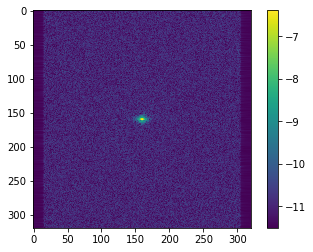

In [14]:
plt.imshow(np.log(1e-5+np.abs(ksp_npy)))
plt.colorbar()

In [15]:
rec = ifft_c3(kspace_square)
rec_abs = transforms.complex_abs(rec)
img, mean, std = transforms.normalize_instance(rec_abs, eps=1e-11)

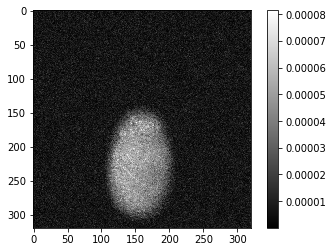

In [16]:
rec_npy = tensor_to_complex_np(rec)
plt.imshow(np.abs(rec_npy),cmap='gray')
plt.colorbar()

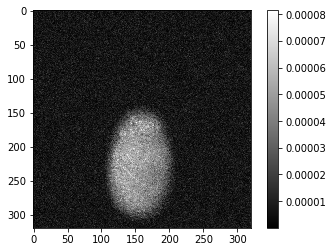

In [17]:
plt.imshow(rec_abs,cmap='gray')
plt.colorbar()

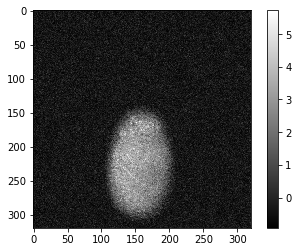

In [18]:
plt.imshow(img,cmap='gray')
plt.colorbar()

# Testing of data loader

In [19]:
train_loader, dev_loader, display_loader = create_data_loaders(argsobj)

In [20]:
for ksp,inp, tgt,_,_,_ in train_loader:
    print(ksp.shape,ksp.dtype)
    break

torch.Size([3, 2, 320, 320]) torch.float32


In [21]:
inp_npy = to_cplx(inp,0)
tgt_npy = to_cplx(tgt,0)

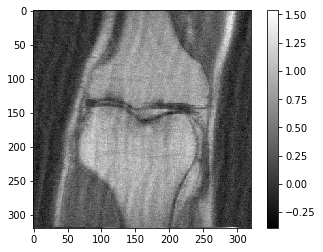

In [22]:
plt.imshow(np.real(inp_npy),cmap='gray')
plt.colorbar()

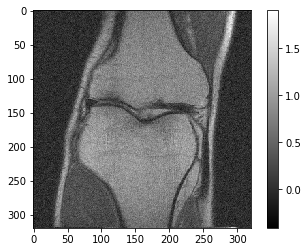

In [23]:
plt.imshow(np.real(tgt_npy),cmap='gray')
plt.colorbar()

In [24]:
from common.evaluate import psnr

In [25]:
psnr(np.abs(tgt_npy),np.abs(inp_npy))

27.00181668713904

# testing model forward

In [26]:
from models.dautomap.train_dautomap import build_model

In [27]:
model = build_model(argsobj)

args(center_fractions=[0.08], accelerations=[2], challenge='singlecoil', data_path=PosixPath('/media/student1/NewVolume/MR_Reconstruction/datasets/fastmri'), resolution=320, sample_rate=0.1, batch_size=3, device='cuda', data_parallel=False, residual=False, dcblock=False)


In [28]:
model

dAUTOMAP(
  (domain_transform): GeneralisedIFT2Layer(
    (idft1): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1), bias=False)
    (idft2): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1), bias=False)
  )
  (domain_transform2): GeneralisedIFT2Layer(
    (idft1): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1))
    (idft2): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1))
  )
  (refinement_block): Sequential(
    (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace)
    (4): ConvTranspose2d(64, 2, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
)

In [29]:
idft1 = model.domain_transform

In [30]:
type(idft1)

models.dautomap.dautomap_model.GeneralisedIFT2Layer

In [31]:
ksp_shifted = transforms.ifftshift(ksp,dim=(-2,-1))

In [32]:
output = idft1(ksp_shifted.cuda())

In [33]:
output.shape

torch.Size([3, 2, 320, 320])

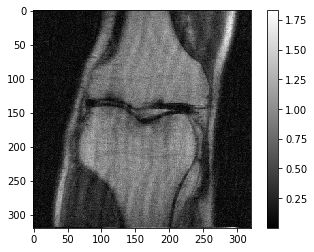

In [34]:
plt.imshow(np.abs(to_cplx(output,0)),cmap='gray')
plt.colorbar()

In [35]:
output = model(ksp_shifted.cuda())

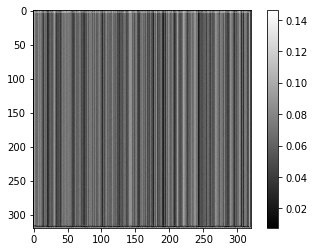

In [36]:
plt.imshow(np.abs(to_cplx(output,0)),cmap='gray')
plt.colorbar()

# overfitting on single image

In [37]:
import torch
from torch.nn import functional as F
from tqdm import tqdm

In [52]:
model = build_model(argsobj)

args(center_fractions=[0.08], accelerations=[2], challenge='singlecoil', data_path=PosixPath('/media/student1/NewVolume/MR_Reconstruction/datasets/fastmri'), resolution=320, sample_rate=0.1, batch_size=3, device='cuda', data_parallel=False, residual=False, dcblock=False)


In [53]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
model.train()
v = []
for _ in tqdm(range(200)):
    output = model(ksp_shifted.cuda())
    loss = F.mse_loss(output, tgt.cuda(),reduction='sum')
    v.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

100%|██████████| 200/200 [00:14<00:00, 13.88it/s]


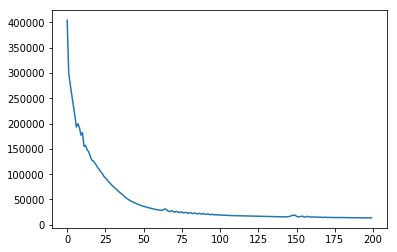

In [54]:
plt.plot(v)

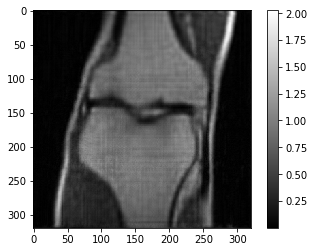

In [55]:
model.eval()
output = model(ksp_shifted.cuda())
plt.imshow(np.abs(to_cplx(output,0)),cmap='gray')
plt.colorbar()

In [56]:
F.mse_loss(output, tgt.cuda(),reduction='sum')

tensor(13442.7598, device='cuda:0', grad_fn=<MseLossBackward>)

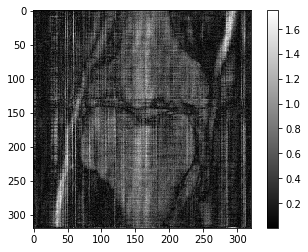

In [57]:
idft1 = model.domain_transform
out1= idft1(ksp_shifted.cuda())
plt.imshow(np.abs(to_cplx(out1,0)),cmap='gray')
plt.colorbar()